# 분석 및 시각화

로스팅 수준별 기술 통계량:

               count       mean       std   min   25%   50%   75%   max
roast                                                                  
dark             5.0  88.200000  3.898718  84.0  86.0  87.0  90.0  94.0
light          287.0  93.522648  1.450347  87.0  93.0  94.0  94.0  97.0
medium         259.0  92.274131  1.848461  85.0  91.0  92.0  93.0  96.0
medium-dark     39.0  91.871795  2.811438  84.0  91.0  92.0  94.0  96.0
medium-light  1490.0  93.226174  1.374912  87.0  92.0  93.0  94.0  98.0

로스팅 수준별 평점 차이에 대한 ANOVA 테스트 결과:
F-통계량: 47.91, p-값: 0.0000

로스팅 수준별 최고 가성비 커피 추천:

                              name         roast  \
1765            Pike’s Place Blend          dark   
1896  Panama La Mula Geisha Washed         light   
1732                Espresso Blend        medium   
673                100% Guatemalan   medium-dark   
763       Karen J Kona Red Bourbon  medium-light   

                                     origin  rating  100g_USD  value_for_money  
17

C:\Users\ryous\AppData\Local\Temp\ipykernel_127248\3585737368.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data, x = 'roast', y = 'rating', palette = 'Set2')


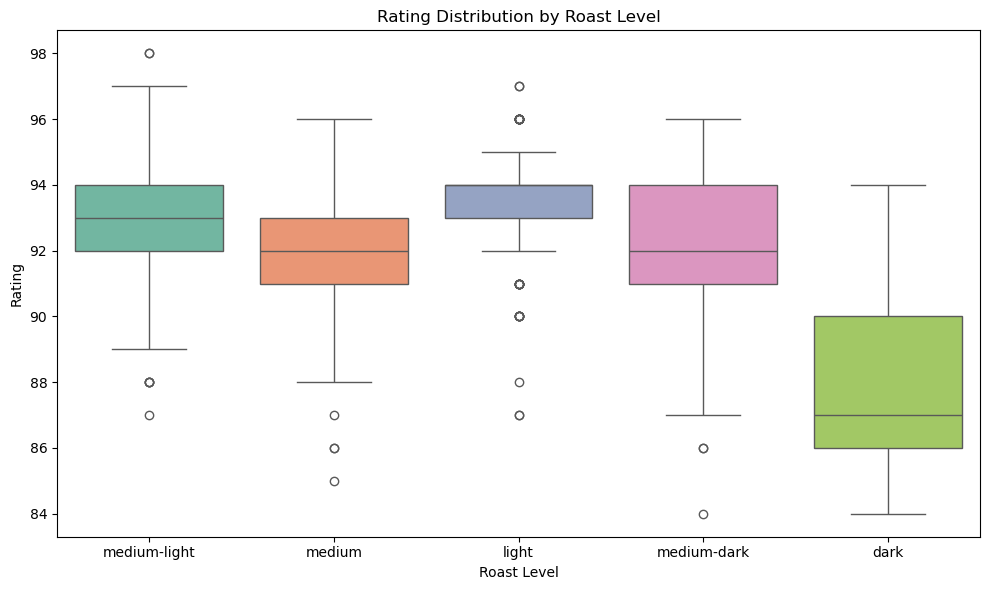

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# 데이터셋 로드
file_path = 'coffee_analysis.csv'
data = pd.read_csv(file_path)

# 데이터 전처리
# 결측값 처리: origin_1, rating, roast, 100g_USD에 결측값이 있는 행 제거
data = data.dropna(subset = ['origin_1', 'rating', 'roast', '100g_USD'])

# 산지 통합: origin_1과 origin_2를 결합하여 통합된 산지(origin) 컬럼 생성
data['origin'] = data['origin_1'] + ', ' + data['origin_2']

# 로스팅 수준 표준화: 모든 로스팅 수준을 소문자로 변환
data['roast'] = data['roast'].str.lower()

# 로스팅 수준별 기술 통계량 출력
print("로스팅 수준별 기술 통계량:\n")
descriptive_stats = data.groupby('roast')['rating'].describe()
print(descriptive_stats)

# 통계 분석: ANOVA 테스트
# 로스팅 수준별 그룹화하여 평점을 추출하고 ANOVA 테스트 수행
anova_results = f_oneway(*[data[data['roast'] == roast]['rating'] for roast in data['roast'].unique()])
print("\n로스팅 수준별 평점 차이에 대한 ANOVA 테스트 결과:")
print(f"F-통계량: {anova_results.statistic:.2f}, p-값: {anova_results.pvalue:.4f}\n")

# 추천: 로스팅 수준별 가성비가 가장 높은 커피 추천
# 가성비 계산: 평점을 가격(100g당 USD)으로 나눔
data['value_for_money'] = data['rating'] / data['100g_USD']

# 각 로스팅 수준에서 가성비가 가장 높은 커피 선택
best_value_coffees = data.loc[data.groupby('roast')['value_for_money'].idxmax(), ['name', 'roast', 'origin', 'rating', '100g_USD', 'value_for_money']]

# 추천 결과 출력
print("로스팅 수준별 최고 가성비 커피 추천:\n")
print(best_value_coffees)

# 시각화: 로스팅 수준별 평점 분포
# Visualization: Rating Distribution by Roast Level
plt.figure(figsize = (10, 6))
sns.boxplot(data = data, x = 'roast', y = 'rating', palette = 'Set2')
plt.title('Rating Distribution by Roast Level')
plt.ylabel('Rating')
plt.xlabel('Roast Level')
plt.tight_layout()
plt.show()

# 모델링

In [2]:
import pandas as pd

# 데이터셋 로드
file_path = 'coffee_analysis.csv'
data = pd.read_csv(file_path)

# 데이터 전처리
# 의미 없는 변수 제거
data = data.drop(['name', 'review_date', 'desc_1', 'desc_2', 'desc_3'], axis = 1)

# 결측값 처리: 모든 변수에 결측값이 있는 행 제거
data = data.dropna()

# 타겟 변수 저장
target = data['rating']
data = data.drop('rating', axis = 1)

# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
cols = data.columns[data.dtypes == object]

for col in cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])


# 검증 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size = 0.2, random_state = 0)

# 모델 학습 및 평가
# 랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth = 10, n_estimators = 400, random_state = 0)
rf.fit(X_train, y_train)
pred = rf.predict(X_val)

# MSE로 평가
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, pred)
print('MSE: ', mse)

MSE:  1.7391693214120356
